# Diabetes 30‑Day Readmission Prediction
This notebook reproduces the end‑to‑end pipeline described in ChatGPT's analysis:
data cleaning, exploratory analysis, feature engineering, class balancing, model training,
evaluation, and SHAP interpretation.

**Dataset files expected in the working directory:**
- `diabetic_data.csv`
- `IDS_mapping.csv`

Install missing libraries before running (e.g. `xgboost`, `shap`).

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


/home/arjay55/code/pykan-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load raw data

In [2]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()


Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
# Drop weight (97% missing) and impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]
print('After cleaning:', df.shape)

After cleaning: (100111, 49)


### 2.1 Map admission/disposition/source IDs

In [6]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')

print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

# %% [markdown]
# ### 2.2 Aggregate ICD‑9 diagnosis codes

After applying mapping with converted keys:
admission_type_id
 Physician Referral                                52882
HMO Referral                                       18738
Clinic Referral                                    18226
 Transfer from another health care facility         5227
 Transfer from a Skilled Nursing Facility (SNF)     4690
 Court/Law Enforcement                               320
 Emergency Room                                       18
Transfer from a hospital                              10
Name: count, dtype: int64


In [7]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    if 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    if 520 <= code <= 579 or code == 787:
        return 'Digestive'
    if 250 <= code <= 251:
        return 'Diabetes'
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


# %% [markdown]
# ### 2.3 Simplify medication change indicators

In [8]:

df['change'] = (df['change'] == 'Ch').astype(int)
df['diabetesMed'] = (df['diabetesMed'] == 'Yes').astype(int)


In [9]:

df.drop(columns=['encounter_id','patient_nbr','examide','citoglipton'], inplace=True, errors='ignore')


# %% [markdown]
# ## 3. Train‑test split & preprocessing

In [10]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))


# %% [markdown]
# ### 3.1 Balance training set by random oversampling

Train size: (70077, 44) Pos rate: 0.113
Test size: (30034, 44) Pos rate: 0.113


In [11]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=42)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())


# %% [markdown]
# ### 3.2 One‑hot encode categorical variables

Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


In [12]:

cat_feats = X_train_bal.select_dtypes(include='object').columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# Fix column names to remove special characters that XGBoost doesn't allow
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Scale numeric
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])


# %% [markdown]
# ## 4. Model training

In [13]:

logreg = LogisticRegression(max_iter=200, solver='lbfgs', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=42)

logreg.fit(X_train_bal_enc, y_train_bal)
rf.fit(X_train_bal_enc, y_train_bal)
xgb.fit(X_train_bal_enc, y_train_bal)


# %% [markdown]
# ## 5. Evaluation on original test set

/home/arjay55/code/pykan-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)


# %% [markdown]
# ### 5.1 Confusion matrix for best model (XGBoost)

Logistic Regression  Precision: 0.123 Recall: 0.950 F1: 0.218 ROC-AUC: 0.651
Random Forest        Precision: 0.178 Recall: 0.568 F1: 0.271 ROC-AUC: 0.663
XGBoost              Precision: 0.182 Recall: 0.446 F1: 0.259 ROC-AUC: 0.637


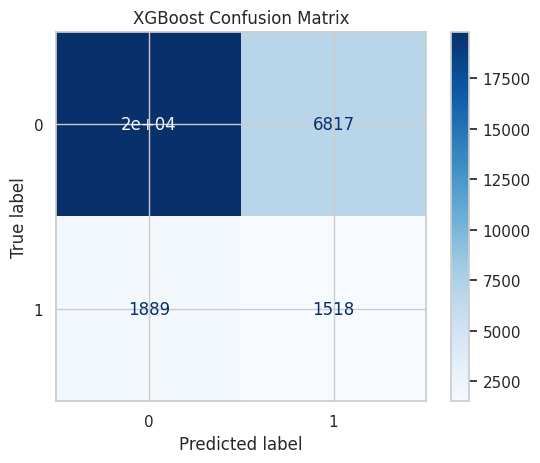

In [15]:

ConfusionMatrixDisplay.from_predictions(y_test, preds['XGBoost'], cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


# %% [markdown]
# ## 6. SHAP interpretation (XGBoost)

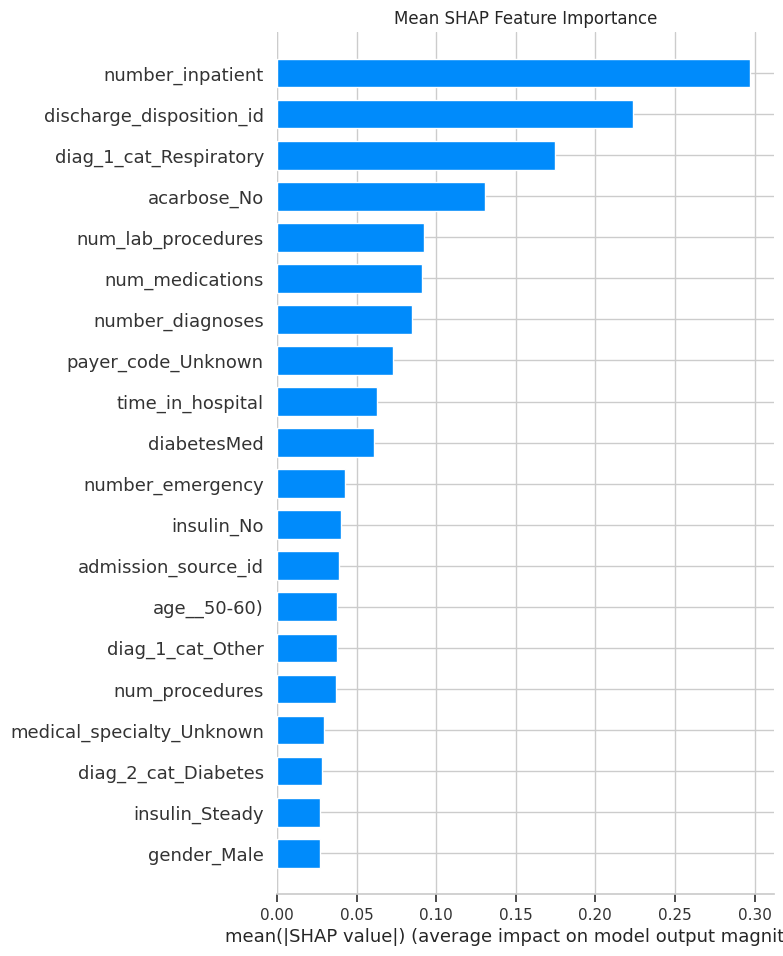

In [16]:

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_enc, check_additivity=False)

# Summary plot (bar)
shap.summary_plot(shap_values, X_test_enc, plot_type='bar', show=False)
plt.title('Mean SHAP Feature Importance')
plt.show()



